#  Recall weights and Confidence in Neural Networks

We  explore two concepts:

**Recall weights**<br>
The Neural network divides the inputs according the difference between the input vector and a representation vector , each of this divisions have a different first layer set of weights that helps the neural network to converge better to the result<br>
**Confidence** <br>
The Neural network computes a confidence value as the same time that process the inputs it represents the similarity of previously seen inputs againts the evaluation input<br>


## Model

We will use the regression model from the Baseline.ipynb nootebok because it was the case with the poorest performance because the data doesnt cover all the search space  (only 1000 samples) <br>
The function to regress is **(x1 - x2) + (x3 * x3)** 
All the inputs and outputs are normalized between **(-1,1 )** <br>

#### Model Pipeline
**Training** <br>
Inputs --> normalize&Cliping --> compute Representation_Vector --> Recall Weights --> model --Output--> loss --> update weights -->update recall weights

**Evaluation** <br>
Inputs --> normalize&Cliping --> compute Representation_Vector --> Recall Weights --> model --Output--> ask for supervision if required--> update recall weights--> denormalize output

## Representation vector 

First step is to compute a vector that represent the training set  in the case of this model it will be the mean of each input of the training set so: <br>
**Vr = [X0mean, X1 mean ,X3mean]**

The representation vector can be any mathematical model that characterize well the data (weighted mean, trigonometric expresion...)

## Recall weights

The recall weights are the first layer of a neural network model.
The difference between  the representation vector(**Vr**) and the input vector (**Vx**) will create divisions , each of this divisions will have a recall weight associated. For this baseline we will use [cosine similarity](https://pytorch.org/docs/stable/nn.html?highlight=cosine#torch.nn.CosineSimilarity) as the mesasurement of the diference between two vectors:

**Vdiff = cosine_similarity (Vr,Vx)**

Vdiff can be computed with another distance representation as angular distance, etc

## Divisions

If the difference between the vectors is greather than the  hyperparameter  called **eps**  ( in the notebook eps is 0.1) <br>
A new division and a new set of wights will be created , each division will keep track of the prediction (Y) associated to that division<br> 
Each Vector difference (Vdiff) and prediction(Y) of the input will be meaned with the Vdiff and Y that represent the division so each division will have a Vdiffm and Ymean :

**Divisions  = (Vdiff-n * ESP, Vdiff + n * ESP) , n = 0,1,2,3... <br>
Vdiffm = (Vdiffm + Vdiff) /2  <br>
Ymean = ( Ymean + Y )/2**


## Confidence

The confidence meter doesn't represent the correctness of the prediction. The confidence meter tries to emulate the confidence express by a person during a decision , the most the current situation  looks like a previous situation the most confidence is expresed by the person.<br>
The confidence meter could be use to ask for supervision to a user or to another algorithm  if the confidence falls below a threshold 

Confidence is expressed by the difference  of the difference vector(Vdiff) and the difference vector mean of each division(Vdiffm) plus the difference of the mean output associated to that division  (Ymean) and the prediction (Y)

**C = 1 -( abs(Vdiffm -Vdiff) + abs(Ymean - Y) )**

## Training 

Train the model is performed in two steps :
1. Train the model without generating the recall weights this will give us a baseline for the recall weights(first layers of the model)
2. Train the model only updating the recall weights wiht a lower learning rate, this will update the weights according their vector difference

## Evaluation 

Evaluation can be performed with or without supervision , when supervision enable  if the confidence of the prediction falls from a deifned threshold the model will ask for supervsion and it will update the recall weights only accordingly the feedback from the supervision routine output 

## Prerequisites
- Python 3 
- Pytorch
- Jupyter noteboks enviroment




## Running
Donwload and execute the notebooks the cvs data is included 

In [1]:
import os
import math
import random 
import pickle
import pandas as pd #data manipulation
import numpy as np # linear algebra
import matplotlib.pyplot as plt #plotting
import seaborn as sns #statistic graphics plotting
import cv2 #opencv
import gc #garbage collector
from tqdm import tqdm #progress meter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score

import torch # if neural networks
from torch import nn
import torch.nn.functional as F
import torchvision #cnn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms 
from torch import optim


# Regression task

The function to regress is (x1 - x2) + (x3 * x3)

In [2]:
regression_df = pd.read_csv('./data/csv/regression.csv')
print(len(regression_df))
regression_df.head()


999


x1  x2  x3    y  class
0  -4  -6  -9   83      1
1   9   6  -1    4      1
2  -1 -10   3   18      1
3  -2  10   0  -12      0
4   1   0 -10  101      1

In [3]:
#clipping and normalization between -1,1
#clipp not required
#save max for each variables
nMax_data = regression_df.max()
regression_df.x1 = regression_df.x1/regression_df.x1.max()
regression_df.x2 = regression_df.x2/regression_df.x2.max()
regression_df.x3 = regression_df.x3/regression_df.x3.max()
regression_df.y = regression_df.y/regression_df.y.max()

In [4]:
#all evaluation data will be clip by max and normalize by then , and the output will be denormalize multyplying by the max

In [5]:
features = ['x1','x2','x3']
x = regression_df[features]
y = regression_df.y
train_x,eval_x,train_y,eval_y = train_test_split(x,y,train_size = 0.8,random_state = 3)

In [6]:
#get the vector mean , the vecor mean can be obtenined by performing a running mean during the first epoch of training
x_means = x.mean()
print(x_means.values)

[-0.01091091  0.01811812  0.03083083]


In [7]:

#we will use pickle for the dictionary with the metadata_ substitute as requires
def read_mem_dict(name):
    '''read(pickle) a list of dictionaries with the means and the name of the recall weights associated'''
    memory_dictionary = []
    try:
        pickle_file = open(name,'rb')
        memory_dictionary = pickle.load(pickle_file)
        pickle_file.close()
    except:
        print('operation failed returning and empty list')    
    return memory_dictionary

def save_mem_dict(name,memory_dict):
    '''write(pickle) a list of dictionaries with the means and the name of the recall weights associated'''
    try:
        pickle_file = open(name,'wb')
        pickle.dump(memory_dict,pickle_file)
        pickle_file.close()
    except:
        print('operation failed')    
    return 0
###########sigmoid encode
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [8]:
#angular an cosine similarity  example
x1 = torch.tensor(train_x.values[0],dtype = torch.float32)#dataframe rec
x2 = torch.tensor(train_x.values[85],dtype = torch.float32)#dataframe rec
cos_sim = F.cosine_similarity(x1,x2,dim = 0)
angular_distance= torch.acos(cos_sim)/math.pi
angular_similarity = 1 -angular_distance
print(x1,x2,cos_sim,angular_distance,angular_similarity)

tensor([-0.4000, -0.9000, -0.5000]) tensor([-0.6000,  0.7000,  0.2000]) tensor(-0.4702) tensor(0.6558) tensor(0.3442)


In [9]:
class Regressor(nn.Module):
    def __init__(self,mem_dict,mean_vector,eps =0.1):
        super(Regressor,self).__init__()
        self.mem_dict = mem_dict
        self.recall_weight_path = './model_zoo/AIHI/regressor/{}.pt'
        self.recall_file_name = ''
        self.eps = eps
        self.prediction_y = 0.0
        self.confidence = 0.0
        self.mean_vector = torch.tensor(mean_vector,dtype = torch.float32)
        #network
        self.recall  =  nn.Linear(3,3) # add a layer for recall weights
        self.out = nn.Linear(3,1)
 
        
    def forward(self,x,recall_enable = True):
        if recall_enable:
            xn_confidence,xn_mean_index = self.get_recall_weights(x)
            
        y  = F.relu(self.recall(x))
        self.prediction_y  = self.out(y)
        if recall_enable:
            self.confidence = self.get_confidence(self.prediction_y ,xn_confidence,xn_mean_index)
        return self.prediction_y ,self.confidence
    
    #we will read the mem_dict and expose the mean values
    def get_recall_weights(self,data):
        #working values
        rows = data.shape[0] #data came in batch format [B,C,H,W,...Xn]
        means = []
        mean = 0.0
        xn_name =''
        closest_mean_diff = 10000.0
        
        xn_confidence = 0.0
        xn_mean = 0.0 
        xn_mean_index = 0
        mean_diff = 0.0
        
        #Compute the cosine similarity
        cos_sim = F.cosine_similarity(self.mean_vector,data[0],dim = 0)
       # angular_distance= torch.acos(cos_sim)/math.pi
        #angular_similarity = 1 -angular_distance
        #print(x1,x2,cos_sim,angular_distance,angular_similarity)
        
       # xn_mean = torch.mean(data[0]).data.numpy()
        xn_mean = cos_sim.data.numpy()
        #Format of memory dict nMem_dict = [{'xm':0,'N':0,'y':0,'yw':0,,'file':1,'confidence':0.0},{'xm':0,'N':0,'y':0,'yw':0,,'file':'1.pth','confidence':0.0}]
        if self.mem_dict :
            for indx,dictionary in enumerate(self.mem_dict):
                xm = float( dictionary['xm'])
                mean_diff = abs(xm - xn_mean)
                if (closest_mean_diff > mean_diff):
                    closest_mean_diff =  mean_diff
                    xn_mean_index = indx
             
            closest_mean = self.mem_dict[xn_mean_index]['xm']
            #review if 
            if ( ( closest_mean+self.eps) > xn_mean) and (xn_mean > (closest_mean -self.eps)):   
                xm = self.mem_dict[xn_mean_index]['xm'] 
                self.recall_file_name  = self.recall_weight_path.format(self.mem_dict[xn_mean_index]['file'])
                self.recall.load_state_dict(torch.load( self.recall_file_name))
                self.mem_dict[xn_mean_index]['xm'] = (xm + xn_mean )/2
                self.mem_dict[xn_mean_index]['N'] = self.mem_dict[xn_mean_index]['N'] +1
                
                xn_confidence = np.abs(xm - xn_mean)             
                
            elif self.training : # New entry load weights from closest mean
                print('create new entry no empty dict')
                self.recall_file_name = self.recall_weight_path.format(self.mem_dict[xn_mean_index]['file'])
                self.recall.load_state_dict(torch.load( self.recall_file_name))
                #create new entry
                new_name =  self.mem_dict[-1]['file'] +1
                self.recall_file_name = self.recall_weight_path.format(new_name)
                new_dict_entry = {'xm':xn_mean,'N':1,'yp':0,'yt':0,'file':new_name ,'confidence':0}   
                self.mem_dict.append(new_dict_entry)
                xn_confidence = 0
                xn_mean_index = 0
                
            else:#during evaluation do not  create a new entry and load new entry
 
                xm = self.mem_dict[xn_mean_index]['xm'] 
                self.recall_file_name  = self.recall_weight_path.format(self.mem_dict[xn_mean_index]['file'])
                self.recall.load_state_dict(torch.load( self.recall_file_name))
                self.mem_dict[xn_mean_index]['xm'] = (xm + xn_mean )/2
                self.mem_dict[xn_mean_index]['N'] = self.mem_dict[xn_mean_index]['N'] +1
                xn_confidence = np.abs(xm - xn_mean)
                
                
        else:  # New entry do  not load any weight
            
            print('create a new entry empty')  
            new_dict_entry = {'xm':xn_mean,'N':1,'yp':0,'yt':0,'file':0,'confidence':0}   
            self.mem_dict.append(new_dict_entry)
            self.recall_file_name = self.recall_weight_path.format(0)
            xn_mean_index = 0
            xn_confidence = 0
            
           
        return xn_confidence,xn_mean_index

    def get_confidence(self,y,xn_confidence,xn_mean_index,x_metadata = None):
        yp = float(self.mem_dict[xn_mean_index]['yp'])
        self.mem_dict[xn_mean_index]['yp'] = (yp + y)/2
        y1 = y.data.numpy()
        y_diff = abs(yp - y1) #np.abs(yp - y1)
        confidence =  (1 - abs(y_diff + xn_confidence) ) #* (1-1*Nas)
        self.mem_dict[xn_mean_index]['confidence'] = (self.mem_dict[xn_mean_index]['confidence'] + confidence) /2
        #print('xn_confidence',xn_confidence,'y_diff',y_diff,'confidence',confidence,'y',y)
        return confidence

    def update_recall_weights(self):#new algorithm to update
        #compute the recall weights
        #with self.mem_dict update the weights
        #print('1',self.recall_file_name)
        torch.save(self.recall.state_dict(),self.recall_file_name)
        return 0
    
        

In [10]:
def check_confidence(output,confidence):#,memory_location,y,loss):
    nTreshold = .8
    if confice < nThreshold:
        print('routine to ask for feedback can ask to user or to another algoritm ,Model output ',output, ' Please insert the correct output')
        input_text = input ('correct result ')
        input_number = int(input_text)
    return input_number 

In [11]:
def ovefititing_training(model,loss_function,optimizer,input_data,output_data,max_epochs=20,use_recall= True):
    '''Train the model for one wimple input until overfit 
   the number of pass required will then the epochs(the time of passed for all the training set) '''
    running_loss = 0
    accuracy = 0
    input_indx = random.randint(0,len(input_data))
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #get data
        input_tensor = torch.tensor(input_data.values[input_indx],dtype = torch.float32)#dataframe rec
        output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
        #move to device
        #input_tensor = input_tensor.to(device)
        #output_tensor =  output_tensor.to(device)
        output_tensor = output_tensor[None][None]#adjust to output size
        #clean gradients
        optimizer.zero_grad()
        prediction ,confidence = model(input_tensor[None],use_recall)#same as unsqueeze(input_tensor,x)
       # print(prediction.shape,prediction,output_tensor.shape,output_tensor)
        loss = loss_function(prediction,output_tensor)
        loss.backward()
        optimizer.step()
        if use_recall:
            model.update_recall_weights()
        running_loss += loss.item()
        
    print('loss',running_loss)
          
    #model evaluation
    model.eval()
    with torch.no_grad():
        #get data
        input_tensor = torch.tensor(input_data.values[input_indx],dtype = torch.float32)#dataframe rec
        #output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
        #move to device
        #input_tensor = input_tensor.to(device)
        prediction,confidence = model(input_tensor[None],use_recall)#same as unzquezee 
        prediction_num = prediction.data.numpy()
        print('x:',input_data.values[input_indx],'y:',output_data.values[input_indx])
        print('Model output ý:',prediction_num, 'Expected output y :', output_data.values[input_indx],'confidence:',confidence)
    

In [17]:
def train_model(model,loss_function,optimizer,input_data,output_data,max_epochs=20,use_recall= True):
    '''Train for all the dataset without early stopping batch size 1'''
    running_loss = 0
    accuracy = 0
    data_len = len(input_data)
    for epoch in tqdm(range(max_epochs)):
        model.train()
        #running_loss = 0
        for indx in range(data_len):
            #get data
            input_tensor = torch.tensor(input_data.values[indx],dtype = torch.float32)#dataframe rec
            output_tensor = torch.tensor(output_data.values[indx],dtype = torch.float32)
            #move to device
            #input_tensor = input_tensor.to(device)
            #output_tensor =  output_tensor.to(device)
            output_tensor = output_tensor[None][None]#adjust to output size
            #clean gradients
            optimizer.zero_grad()
            prediction,confidence = model(input_tensor[None],use_recall)#same as unsqueeze(input_tensor,x)
            
            loss = loss_function(prediction,output_tensor)
            loss.backward()
            optimizer.step()
            if use_recall:
                model.update_recall_weights()
            running_loss += loss.item()
    print('epoch',epoch, 'running_loss',running_loss)
    #save the model
    torch.save(model.state_dict(), './model_zoo/AIHI/regressor/regressor.pth')
    print('...model save')
      
    #model evaluation
def eval_model(model,input_data,output_data,nTreshold = 0.95,optimizer=None,loss_function= None,use_recall = True):
    model.eval()
    output_a =[] 
    
    data_len = len(input_data)
    with torch.no_grad():
        
        for indx in tqdm(range(data_len)):
            #get data
            input_tensor = torch.tensor(input_data.values[indx],dtype = torch.float32)#dataframe rec
            
            #output_tensor = torch.tensor(output_data.values[input_indx],dtype = torch.float32)
            #move to device
            #input_tensor = input_tensor.to(device)
            output,confidence = model(input_tensor[None],use_recall)#same as unzquezee
            #print(input_tensor,output,output_data.values[input_indx])
            output_num = [output.data.numpy().item(),confidence]   
            output_a.append(output_num)
            
            #check confidence routine
            if loss_function and check_confidence < nTreshold:
                ground_truth = check_confidence(output,confidence)
                loss = loss_function(output,ground_truth)
                loss.backward()
                optimizer.step()
                model.update_recall_weights()
                
    input_indx = random.randint(0,data_len)
    print('x:',input_data.values[input_indx],'y:',output_data.values[input_indx])
    print('Sample Model output ý:',output_a[input_indx][0],'confidence',output_a[input_indx][1], 'Expected output y :', output_data.values[input_indx])
    return np.array(output_a)

In [28]:
memory_path = './model_zoo/AIHI/regressor/memory_index.pkl'
recall_weight_path = './model_zoo/AIHI/regressor/{}.pth'
nMem_dict = read_mem_dict(memory_path)


operation failed returning and empty list


In [29]:
regressor = Regressor(nMem_dict,x_means.values,0.1)
MSE_criterion = nn.MSELoss()

In [30]:
adam_optimizer = optim.Adam(regressor.parameters(), lr=0.001)
recall_optimizer = optim.Adam(regressor.recall.parameters(), lr=0.0001)

In [31]:
nMem_dict

[]

##  Try overfiting training (check if a single input can converge)

In [32]:
nEpochs = 500
ovefititing_training(regressor,MSE_criterion,adam_optimizer,train_x,train_y,nEpochs,use_recall = False)

100%|██████████| 500/500 [00:00<00:00, 1757.53it/s]

loss 0.7267614232757609
x: [0.7 0.1 0.6] y: 0.3559322033898305
Model output ý: [[0.3559324]] Expected output y : 0.3559322033898305 confidence: 0.0


## Traning strategy 
1 first train the model without the recall weights division

2- Train the model only the recall weights

In [33]:
nEpochs = 500
train_model(regressor,MSE_criterion,adam_optimizer,train_x,train_y,nEpochs,use_recall = False)

100%|██████████| 500/500 [03:46<00:00,  2.20it/s]

epoch 499 running_loss 580.2254706733075
...model save


In [34]:

predictions = eval_model(regressor,eval_x,eval_y,use_recall = False)
eval_y_np = np.array(eval_y.values)
for indx in range(len(eval_y_np)):
    print(eval_y_np[indx]*nMax_data.y,predictions[indx][0]*nMax_data.y,predictions[indx][1])
d = np.abs(eval_y_np - predictions[indx][0])
#s = np.abs(eval_y_np) + np.abs(predictions[indx][0])
print("mean difference",np.mean(d))

100%|██████████| 200/200 [00:00<00:00, 13402.04it/s]

x: [-0.8  0.  -0.7] y: 0.3474576271186441
Sample Model output ý: 0.3675529360771179 confidence 0.0 Expected output y : 0.3474576271186441
65.0 67.8306428194046 0.0
83.0 80.98753321170807 0.0
26.0 25.166654020547867 0.0
52.0 56.2609258890152 0.0
86.0 86.41883933544159 0.0
81.0 79.03086280822754 0.0
113.0 107.96831452846527 0.0
70.0 71.49749994277954 0.0
75.0 78.25369191169739 0.0
17.0 16.063335329294205 0.0
96.0 88.42543947696686 0.0
35.0 34.556358337402344 0.0
51.0 53.60802435874939 0.0
7.0 6.758252739906311 0.0
104.0 99.21371626853943 0.0
57.0 60.026939153671265 0.0
18.0 12.670064896345139 0.0
32.0 34.99463438987732 0.0
6.0 0.34532156586647034 0.0
-1.0 -0.9032498151063919 0.0
115.0 109.86453330516815 0.0
70.0 71.42590045928955 0.0
48.0 48.97181010246277 0.0
65.0 66.30750799179077 0.0
12.0 14.104273587465286 0.0
25.0 19.971805542707443 0.0
5.0 3.8856382071971893 0.0
27.0 22.07166436314583 0.0
9.0 7.974151581525803 0.0
74.0 71.90807867050171 0.0
43.0 45.86708629131317 0.0
55.0 56.118458

## Now train only the recall weights

In [41]:
nEpochs = 300
train_model(regressor,MSE_criterion,recall_optimizer,train_x,train_y,nEpochs,use_recall = True)

100%|██████████| 300/300 [04:21<00:00,  1.15it/s]

epoch 299 running_loss 251.62731320800836
...model save


lenght 19


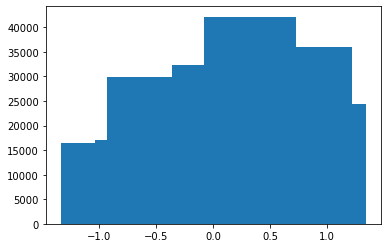

In [42]:
#some statistics
x_list= [c['xm'] for c in nMem_dict]
n_list= [c['N'] for c in nMem_dict]
print('lenght',len(nMem_dict))
plt.bar(x_list,n_list)
plt.show()


In [43]:
nMem_dict

[{'xm': -0.6904197043817962,
  'N': 12865,
  'yp': tensor([[0.2190]], grad_fn=<DivBackward0>),
  'yt': 0,
  'file': 0,
  'confidence': array([[0.82128024]], dtype=float32)},
 {'xm': 0.4348778210558985,
  'N': 25742,
  'yp': tensor([[0.2200]], grad_fn=<DivBackward0>),
  'yt': 0,
  'file': 1,
  'confidence': array([[0.75415355]], dtype=float32)},
 {'xm': 0.9402610519268892,
  'N': 24449,
  'yp': tensor([[0.5416]], grad_fn=<DivBackward0>),
  'yt': 0,
  'file': 2,
  'confidence': array([[0.64651483]], dtype=float32)},
 {'xm': 0.3240758371624285,
  'N': 42172,
  'yp': tensor([[0.0262]], grad_fn=<DivBackward0>),
  'yt': 0,
  'file': 3,
  'confidence': array([[0.8040186]], dtype=float32)},
 {'xm': 0.11580255239387405,
  'N': 28714,
  'yp': tensor([[0.2311]], grad_fn=<DivBackward0>),
  'yt': 0,
  'file': 4,
  'confidence': array([[0.55906236]], dtype=float32)},
 {'xm': -0.28846185735689966,
  'N': 27516,
  'yp': tensor([[0.1483]], grad_fn=<DivBackward0>),
  'yt': 0,
  'file': 5,
  'confidence'

In [44]:
#regressor = Regressor(nMem_dict)
#state_dict = torch.load('./model_zoo/AIHI/regressor/regressor.pth')#'./model_zoo/model_centernet_b1_post_sig.pth'  model_centernet_b1
#regressor.load_state_dict(state_dict)

In [45]:

predictions = eval_model(regressor,eval_x,eval_y,use_recall = True)
eval_y_np = np.array(eval_y.values)
for indx in range(len(eval_y_np)):
    print(eval_y_np[indx]*nMax_data.y,predictions[indx][0]*nMax_data.y,predictions[indx][1])
d = np.abs(eval_y_np - predictions[indx][0])
#s = np.abs(eval_y_np) + np.abs(predictions[indx][0])
print("mean difference",np.mean(d))

100%|██████████| 200/200 [00:00<00:00, 2242.78it/s]

x: [-0.7  0.7 -0.3] y: -0.0423728813559322
Sample Model output ý: 0.022415950894355774 confidence [[0.6224623]] Expected output y : -0.0423728813559322
65.0 66.13527536392212 [[0.93385315]]
83.0 81.40582752227783 [[0.6459329]]
26.0 27.074920922517776 [[0.84003735]]
52.0 55.726855635643005 [[0.90630245]]
86.0 86.59911811351776 [[0.260176]]
81.0 85.0783394575119 [[0.6251235]]
113.0 107.40200340747833 [[0.2820949]]
70.0 72.5693188905716 [[0.92692244]]
75.0 80.40078318119049 [[0.54756457]]
17.0 14.375134855508804 [[0.9262357]]
96.0 87.89894413948059 [[0.41042036]]
35.0 39.01431941986084 [[0.6668333]]
51.0 57.453641057014465 [[0.907398]]
7.0 7.639879405498505 [[0.5937898]]
104.0 99.526531457901 [[0.64741814]]
57.0 57.53154242038727 [[0.97145337]]
18.0 11.665845215320587 [[0.9882707]]
32.0 32.93328666687012 [[0.58435476]]
6.0 11.88422891497612 [[0.8696463]]
-1.0 1.5434946119785309 [[0.5304204]]
115.0 111.10575044155121 [[0.28155774]]
70.0 76.64155006408691 [[0.8182609]]
48.0 45.9597998857498

In [90]:
save_mem_dict(memory_path,nMem_dict)
torch.save(regressor.state_dict(),'./model_zoo/AIHI/regressor/regressor_1.pth')

#  Conclussion

The recall weights and the confidence meter increase the accuracy of the same model in baseline,
Train strategy of training the model then the recall weights improve the accuracy 